In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>
<font color='red' size=5>
    The show so far ... 
</font>


**Summary**

1. Load data
2. Remove features
    * features missing more than 10%
    * features with high correlations to the other features
3. Stage 1 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Scale num. features
        * perhaps better to wait until after 
            1. cat. encoding is done with ordinals
            2. imputation for (all) features
    * Cat. features
        * used Ordinal and OneHot-encoders
        * used custom encoder to include NANs
    * Retrieve column names        
    * Recast all features as needed
4. Stage 2 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Impute remaining features
        * Used `SimpleImputer`
        * `KNNImputer` failed
    * Retrieve column names
    * Recast all features as needed
  

**TODOs**

1. $\checkmark$ ~~Get the columns names of the transformed data after the `Pipeline` / `ColumnTransformer` steps~~
    * _Needed for checking, further exploration, and featuring engineering_
2. Check on the appropriate strategies
    * $\checkmark$ ~~first do cat. encoding with `ColumnTransformer`, then do scaling on numericals in another `Pipeline`~~
    * ~~do everything in a single `Pipeline` taking care of the steps~~ $\to$ everything done with `ColumnTransformer` instead
        * allows individual selection of features for transformations
    * ~~Drop features with many unfilled values (can't do _after_ imputing) or just impute?, then pipeline~~ 
        * $\checkmark$ ~~Drop features with many unfilled values before/after preprocessing?~~
        * $\checkmark$ ~~impute afterwards~~
3. $\checkmark$ ~~Drop features which are mutually correlated; keep only the most relevant ones~~
    * **!!!** do this before first preprocessing stage?

**Notes**
* All transforms were included with `ColumnTransformer`
    * selects cols individually
    * can act as a pipeline
    * retrieve the columns names and ordering
        * _this is important to do the next steps of processing_

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import os

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [5]:
import importlib
import sys
sys.path.append('./helpers/')

## Load the data

In [6]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [7]:
df.price_doc.describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

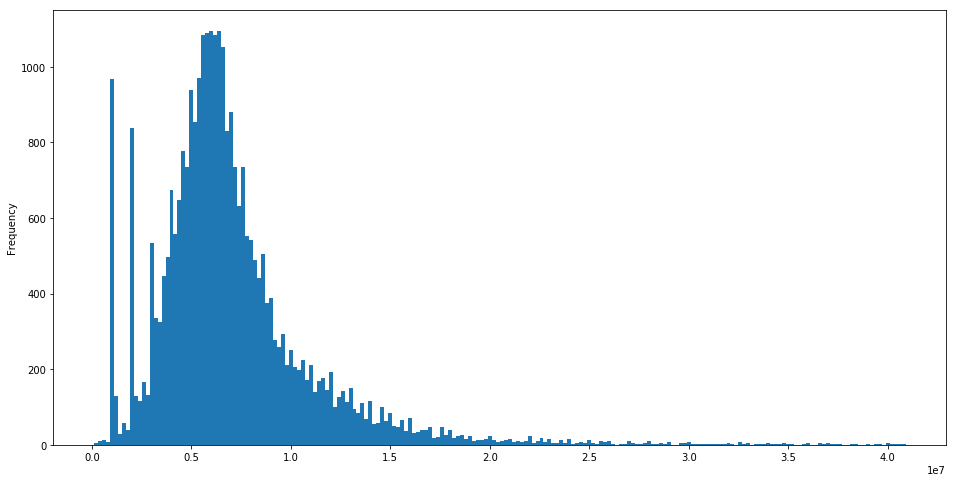

In [8]:
plt.figure(figsize=[16,8])
bins = np.arange(1e5,4.1e7,2e5)
df.price_doc.plot.hist(bins=bins)

**Note** some significantly high outliers in the low-end of the distribution: these may cause problems later

## Drop features

### Characterize the missing values

Drop all features missing more than 10% (arbitrary) of their values

In [9]:
missing = [(c, df[c].isna().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=["column_name", "percent_missing"])
missing = missing[missing.percent_missing > 10]
display(missing.sort_values("percent_missing", ascending=False)[:10])

,column_name,percent_missing
24,hospital_beds_raion,47.392603
7,build_year,44.649011
10,state,44.498047
160,cafe_sum_500_min_price_avg,43.585704
162,cafe_avg_price_500,43.585704
161,cafe_sum_500_max_price_avg,43.585704
6,material,31.413475
8,num_room,31.413475
9,kitch_sq,31.413475
5,max_floor,31.413475


In [10]:
missing = missing.column_name.tolist()

In [11]:
print(len(missing))

35


### Correlation-based feature drop

In [12]:
def get_corr_feature_drop_1(df,threshold=0.95):
    # from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
    # also seen in https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    """
    Basic, minimal feature drop function: 
    blindly selects correlations to drop based on correlation
    """
    # Create correlation matrix, with abs since interested only in magnitude
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    #df.drop(to_drop, axis=1, inplace=True)

    return to_drop

In [13]:
drop_corr_cols = get_corr_feature_drop_1(df,0.90)

### Select the cols to keep

In [14]:
keep_cols = [c for c in df.columns.tolist() if c not in drop_corr_cols+missing]

In [15]:
df = df[keep_cols].copy()

In [16]:
df.shape

(30471, 120)

## Transformations

### Separate cols based on type: to be used for transforms

In [17]:
id_datetime_cols = ['id','timestamp']

In [18]:
float_cols = df.drop(columns=id_datetime_cols).select_dtypes('float').columns.tolist()

int_cols = df.drop(columns=id_datetime_cols).select_dtypes('int').columns.tolist()

num_cols = df.drop(columns=id_datetime_cols).select_dtypes(['int', 'float']).columns.tolist()

string_cols = df.drop(columns=id_datetime_cols).select_dtypes('object').columns.tolist()

### Categorical encoding

In [19]:
print(string_cols)

['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']


In [20]:
df[string_cols].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
2,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
3,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
4,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent


**Note**
* Ordinals:
    * 'ecology'
* OneHots
    * 'sub_area', 'product_type' (but only two vals)
* Binaries
    * the rest
    * _But these will also be considered ordinals_

In [21]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

import categorical_encoding
importlib.reload(categorical_encoding)
from categorical_encoding import OrdinalEncoderNans

onehot_cat_cols = ["sub_area", "product_type"]

ord4_cat_cols = ["ecology"]
ord4_cats = ['poor', 'satisfactory', 'good', 'excellent', 'no data'] # Normally, this is a nested list, ie [[1,2,3,...]]

ord2_cat_cols = [e for e in string_cols if (e not in onehot_cat_cols) & (e not in ord4_cat_cols) ]
ord2_cats = len(ord2_cat_cols)*[["no", "yes"]]

In [22]:
df[onehot_cat_cols].nunique()

sub_area        146
product_type      2
dtype: int64

In [23]:
onehot_sum = sum(df[onehot_cat_cols].nunique())

print(len(num_cols), len(onehot_cat_cols), len(ord2_cat_cols), len(ord4_cat_cols))
sum([len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)])

103 2 12 1


264

### Numerical features in a pipeline

**Note** could also use with the ColumnTransformer, like the cat. features, since is only one transform on the subset

In [24]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
# Use in ColumnTransformer as 
#   ("num_pipe",  num_pipeline, num_cols),


### putting the cat-encs together into the pipeline

In [25]:
pipeline_stage1 = ColumnTransformer([
        ("ignored",   FunctionTransformer(lambda x: x), id_datetime_cols),
        ("num_cols",  StandardScaler(), num_cols),
        ("onehots",   OneHotEncoder(sparse=False), onehot_cat_cols),
        ("ordinals2", OrdinalEncoder(ord2_cats), ord2_cat_cols),   
        ("ordinals4", OrdinalEncoderNans(ord4_cats), ord4_cat_cols),    
    ])

data = pipeline_stage1.fit_transform(df)

In [26]:
data.shape

(30471, 266)

In [27]:
df.shape

(30471, 120)

###  Retrieve the column names

This is a bit specific here, but generalizable

In [28]:
prepro_columns = []
for line in pipeline_stage1.transformers_[:]:
    #print(type(line[1]).__name__ )
    if type(line[1]).__name__ == 'OneHotEncoder':
        # Note: can include old column identifiers in the OHE feature names
        #    with .get_feature_names(ohe_column_names)
        new_cols = line[1].get_feature_names().tolist()
        print(line[0],len(new_cols))
        prepro_columns += new_cols
    elif (line[0] == 'ignored') or (line[0] == 'remainder'):
        pass
    else:
        new_cols = line[2]
        print(line[0],len(new_cols))
        prepro_columns += new_cols
    
print(len(prepro_columns))

num_cols 103
onehots 148
ordinals2 12
ordinals4 1
264


In [29]:
onehot_sum = sum(df[onehot_cat_cols].nunique())

print(len(num_cols), len(onehot_cat_cols), len(ord2_cat_cols), len(ord4_cat_cols))
sum([len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)])

103 2 12 1


264

### Rebuild the DF and re-cast the data type

#### Rebuild the DF

In [30]:
len(id_datetime_cols+prepro_columns)

266

In [31]:
df = pd.DataFrame(data=data, columns=id_datetime_cols+prepro_columns)

#### Re-cast the data types

In [32]:
nr_float_cols = len(prepro_columns)
dtypes_list = ['int','datetime64[ns]'] + nr_float_cols*['float']
dtypes_dict = dict(zip(id_datetime_cols+prepro_columns, dtypes_list))

In [33]:
len(dtypes_dict)

266

In [34]:
df = df.astype(dtypes_dict)

In [35]:
df.head()

,id,timestamp,full_sq,floor,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_top_20_raion,...,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,1,2011-08-20,-0.294873,-0.690013,-0.544788,1.235790,-0.166746,-1.000975,0.312281,-0.329044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,2011-08-23,-0.531523,-0.877987,-0.390702,0.540788,0.877732,-0.583340,0.312281,-0.329044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,3,2011-08-27,-0.294873,-1.065960,-0.622239,0.305019,-0.607483,-0.002814,-0.021749,-0.329044,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2011-09-01,0.914671,0.249854,-0.245700,1.631519,-0.138328,-0.413849,1.648399,-0.329044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,5,2011-09-05,0.599138,-0.690013,-0.448374,0.416700,-1.163354,-0.687151,0.980340,-0.329044,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


## Second stage preprocessing

### Imputing

<font color='green' size=2> 
    Can this be organized with the above into a single pipeline?
    <br/>
    Possibly, since the following stage is an imputer
</font>

In [36]:
from sklearn.impute import SimpleImputer, KNNImputer

**Note** `KNNImputer` failed with a kernel restart $\to$ try again

In [37]:
df.shape

(30471, 266)

In [38]:
pipeline_stage2 = ColumnTransformer([
        ("ignored",   FunctionTransformer(lambda x: x), id_datetime_cols),
        ('imputer', SimpleImputer(strategy='median'), prepro_columns),    
    ])
 
####NOTE: still need to Scale the ordinalTransformed feature

data = pipeline_stage2.fit_transform(df)

### Rebuild the DF and re-cast the data type

In [39]:
df = pd.DataFrame(data=data, columns=id_datetime_cols+prepro_columns)
df = df.astype(dtypes_dict)

In [40]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 266 columns):
id                                       30471 non-null int64
timestamp                                30471 non-null datetime64[ns]
full_sq                                  30471 non-null float64
floor                                    30471 non-null float64
area_m                                   30471 non-null float64
raion_popul                              30471 non-null float64
green_zone_part                          30471 non-null float64
indust_part                              30471 non-null float64
preschool_education_centers_raion        30471 non-null float64
school_education_centers_top_20_raion    30471 non-null float64
healthcare_centers_raion                 30471 non-null float64
university_top_20_raion                  30471 non-null float64
sport_objects_raion                      30471 non-null float64
additional_education_raion               30471 non-nu

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

<font color='black' size=5>
    Modeling
</font>

In [41]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection, preprocessing

from sklearn.linear_model import LinearRegression

In [42]:
train, test, y_train, y_test = train_test_split(df.drop(["id", "timestamp", "price_doc"], axis=1), 
                                                df["price_doc"], random_state=10, test_size=0.25)

In [43]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(train,y_train)
predictions = model.predict(test)

## Evaluation

### Errors

In [44]:
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.min(), predictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions+offset))
print("RMSLE: %f" % (rmsle))

1.4357715590882796
RMSLE: 0.218452


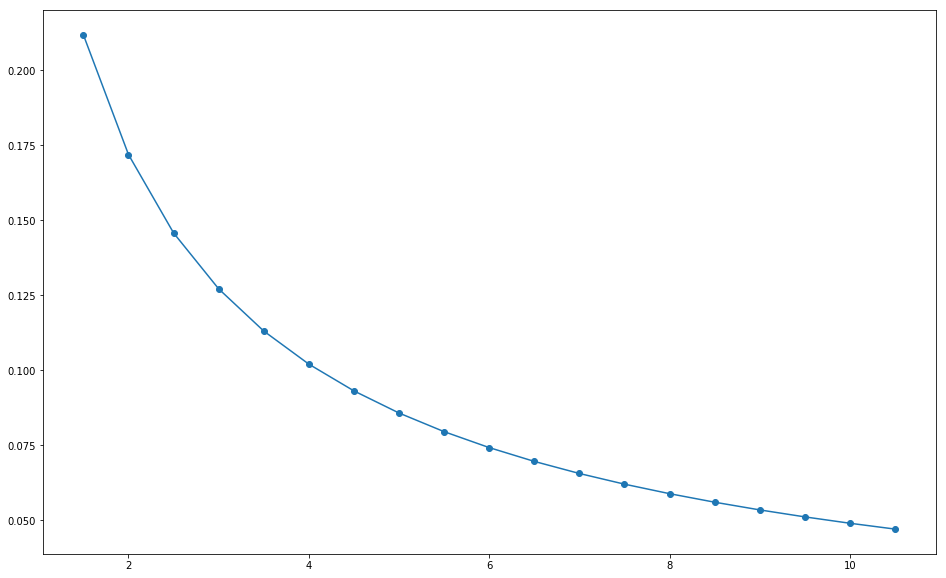

In [45]:
offsets = np.arange(1.5,11.0, 0.5)
errors = []
for x in offsets:
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+x, predictions+x))
    errors.append(rmsle)
errors = np.array(errors)

plt.figure(figsize=[16,10])
plt.plot(offsets, errors, 'o-')

### Distributions

In [46]:
predictions

array([-0.20916885, -0.2921933 ,  0.9334189 , ..., -0.6225742 ,
       -0.79614055,  1.268611  ], dtype=float32)

In [47]:
df.price_doc.describe()

count    3.047100e+04
mean    -8.954364e-17
std      1.000016e+00
min     -1.469244e+00
25%     -4.985391e-01
50%     -1.775352e-01
75%      2.462252e-01
max      2.175468e+01
Name: price_doc, dtype: float64

In [48]:
bin_width = 0.1
bins=np.arange(-2,12 + bin_width, bin_width)
hist_train, _ = np.histogram(y_train, bins=bins)
hist_test, _ = np.histogram(y_test, bins=bins)
hist_pred, _ = np.histogram(predictions, bins=bins)

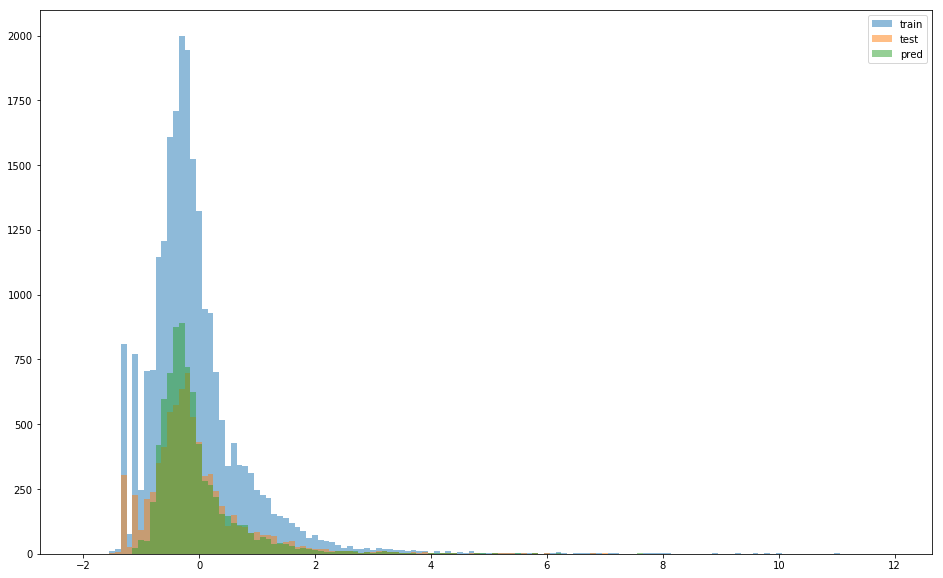

In [49]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

In [50]:
hist_train, _ = np.histogram(y_train, bins=bins, density=True)
hist_test, _ = np.histogram(y_test, bins=bins, density=True)
hist_pred, _ = np.histogram(predictions, bins=bins, density=True)

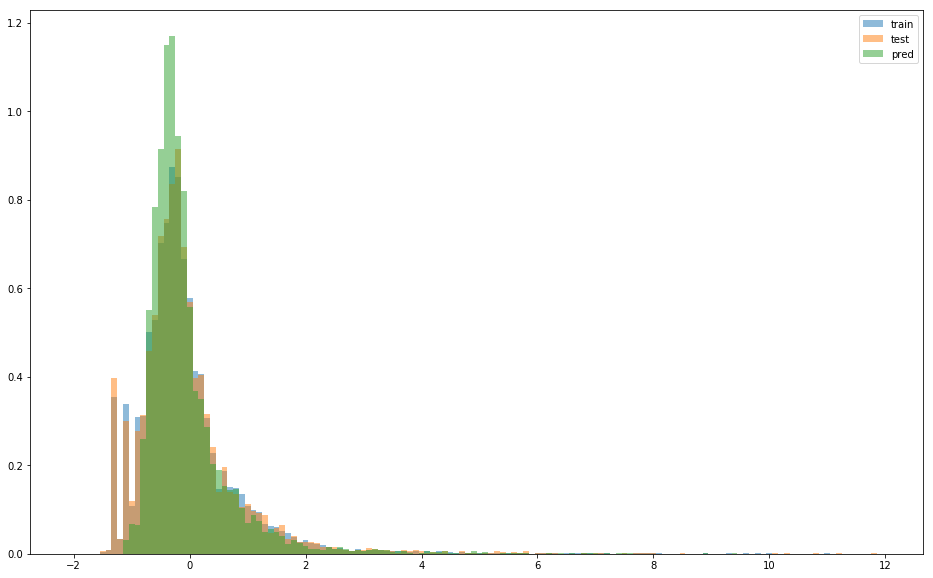

In [51]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

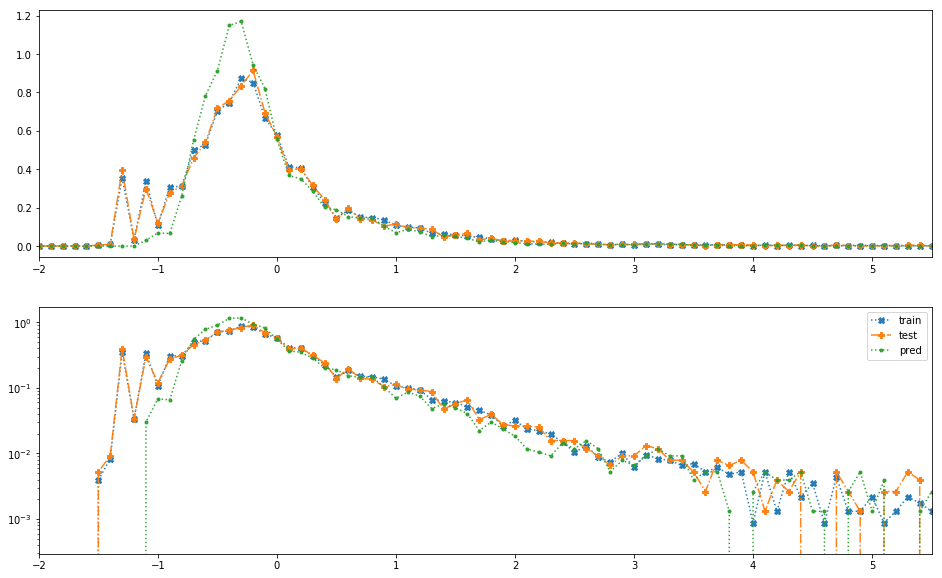

In [52]:
fig, ax = plt.subplots(2,1,figsize=[16,10])

ax =ax.reshape(2)

ax[0].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[0].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[0].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[0].set_xlim(-2.0,5.5)

ax[1].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[1].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[1].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[1].set_yscale('log')
ax[1].set_xlim(-2.0,5.5)
ax[1].legend();

<font color='red' size=5>
    Stop!
</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>

#### Example of everything done in a single pipeline with internal `Pipeline`s and `ColumnTransformer`s 

**Note** check this later

```
from sklearn.linear_model import LinearRegression

# Random data
df = pd.DataFrame({'brand'      : ['aaaa', 'asdfasdf', 'sadfds', 'NaN'],
                   'category'   : ['asdf','asfa','asdfas','as'], 
                   'num1'       : [1, 1, 0, 0] ,
                   'target'     : [0.2,0.11,1.34,1.123]})

# Numeric features and prepro
numeric_features = ['num1']
'''numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])'''
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

# Categorical features and prepro
categorical_features = ['brand', 'category']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing together to specify columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create a final pipeline (Regressor was dropped from this point)
clf = Pipeline(steps=[('preprocessor', preprocessor)])
clf.fit(df.drop('target',1),df['target'])

clf.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

newc_cat_cols = clf['preprocessor'].transformers_[1][1]['onehot']\
                         .get_feature_names(categorical_features).tolist()
# ['brand_NaN' 'brand_aaaa' 'brand_asdfasdf' 'brand_sadfds' 'category_as'
#  'category_asdf' 'category_asdfas' 'category_asfa']
```


<font color='red' size=5>
    Stop!
</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>

### Expanding on the Important Features selected by the classifiers

**Notes**
* only some estimators have this
* **TODO** what does the "importance" score mean?

In [203]:
df_drop_na = df_prepro_data_v0.dropna()
df_drop_na.shape

(6001, 438)

In [159]:
df_drop_na.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6001 entries, 8056 to 30470
Data columns (total 436 columns):
full_sq                                  6001 non-null object
life_sq                                  6001 non-null object
floor                                    6001 non-null object
max_floor                                6001 non-null object
material                                 6001 non-null object
build_year                               6001 non-null object
num_room                                 6001 non-null object
kitch_sq                                 6001 non-null object
state                                    6001 non-null object
area_m                                   6001 non-null object
raion_popul                              6001 non-null object
green_zone_part                          6001 non-null object
indust_part                              6001 non-null object
children_preschool                       6001 non-null object
preschool_quota     

In [157]:
df[col[:10]].corr()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m
full_sq,1.000000,0.161112,0.089649,0.119225,0.032866,-0.006041,0.695444,0.020026,-0.091348,0.056303
life_sq,0.161112,1.000000,0.045090,0.042442,0.011393,-0.002401,0.191024,0.000633,-0.066633,0.061395
floor,0.089649,0.045090,1.000000,0.454488,-0.009043,0.001192,-0.005657,-0.008457,-0.113906,-0.019448
max_floor,0.119225,0.042442,0.454488,1.000000,0.045915,-0.000261,-0.014220,0.020345,-0.072161,-0.092954
material,0.032866,0.011393,-0.009043,0.045915,1.000000,-0.004402,-0.026924,0.038747,-0.034225,0.001182
build_year,-0.006041,-0.002401,0.001192,-0.000261,-0.004402,1.000000,-0.008251,0.000596,0.295053,-0.004572
num_room,0.695444,0.191024,-0.005657,-0.014220,-0.026924,-0.008251,1.000000,0.016950,0.082027,-0.040841
kitch_sq,0.020026,0.000633,-0.008457,0.020345,0.038747,0.000596,0.016950,1.000000,0.048695,-0.023425
state,-0.091348,-0.066633,-0.113906,-0.072161,-0.034225,0.295053,0.082027,0.048695,1.000000,-0.295207
area_m,0.056303,0.061395,-0.019448,-0.092954,0.001182,-0.004572,-0.040841,-0.023425,-0.295207,1.000000


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 0
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

In [211]:
corr.values

array([[ 1.00000000e+00,  1.61111607e-01,  8.96493583e-02, ...,
         4.25737157e-02, -2.76453953e-03,  2.69485871e-02],
       [ 1.61111607e-01,  1.00000000e+00,  4.50901172e-02, ...,
         5.97293993e-03,  7.07136284e-03,  4.52792219e-02],
       [ 8.96493583e-02,  4.50901172e-02,  1.00000000e+00, ...,
         4.75171413e-04, -2.15791278e-03,  1.05889790e-01],
       ...,
       [ 4.25737157e-02,  5.97293993e-03,  4.75171413e-04, ...,
         1.00000000e+00,  5.55435984e-02, -6.54485241e-02],
       [-2.76453953e-03,  7.07136284e-03, -2.15791278e-03, ...,
         5.55435984e-02,  1.00000000e+00, -3.98260382e-02],
       [ 2.69485871e-02,  4.52792219e-02,  1.05889790e-01, ...,
        -6.54485241e-02, -3.98260382e-02,  1.00000000e+00]])

In [218]:
corr[(abs(corr) >= 0.7) & (corr.values != 1.0) ].dropna(how='all').dropna(axis=1, how='all').shape

(256, 256)

In [ ]:
df.dropna()

In [216]:
corr[(abs(corr) >= 0.7) & (corr.values != 1.0) ].head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
full_sq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
life_sq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_floor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
material,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(256, 256)


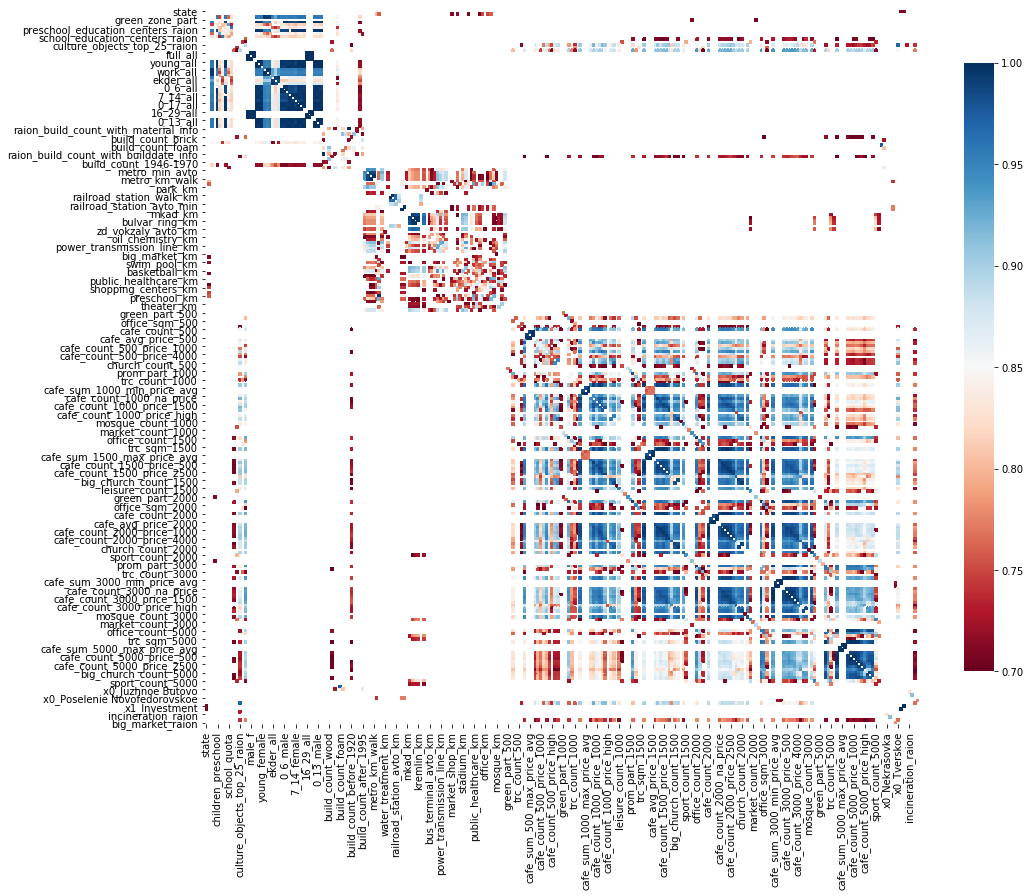

In [220]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 0
col = pp_columns[2:]#new_all_cols[n]

df_drop_na = df_prepro_data_v0[col].dropna()
#corr_cols = df_drop_na.where(df_drop_na.values>0.1).dropna().index.tolist()

corr = df_prepro_data_v0[col].corr().abs()
corr = corr[(corr >= 0.7) & (corr.values != 1.0) ].dropna(how='all').dropna(axis=1, how='all')
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0.7,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

'''clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');''';

### Drop the features which are correlated with other features

**Notes**

* Below are three functions which do this and with the same threshold, they deliver different results


In [228]:
def get_corr_feature_drop_1(df,threshold=0.95):
    # from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
    # also seen in https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    
    # Create correlation matrix, with abs since interested only in magnitude
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    #df.drop(to_drop, axis=1, inplace=True)

    return to_drop

In [229]:
def get_corr_feature_drop_2(df, threshold=0.95):
    # From: https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = df.corr()
    to_drop = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in df.columns:
                    to_drop.append(colname)
                    #del df[colname] # deleting the column from the df

    return to_drop

In [258]:
def get_corr_feature_drop_3(dataset, threshold=0.95):
    # From: https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df
          threshold: Columns are dropped relative to the threshold input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = df.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            print
            if abs(val) >= threshold:
                # Prints the correlated feature set and the corr val
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    to_drop = list(set(drop_cols))#[::-1]

    # Drops the correlated columns
    '''for i in drops:
        col = df.iloc[:, (i+1):(i+2)].columns.values
        df = df.drop(col, axis=1)
    '''    
    
    return to_drop

In [244]:
drop_corr_cols_1 = get_corr_feature_drop_1(df_prepro_data_v0[col])

In [245]:
drop_corr_cols_2 = get_corr_feature_drop_2(df_prepro_data_v0[col])

In [259]:
drop_corr_cols_3 = get_corr_feature_drop_3(df_prepro_data_v0[col])

In [260]:
len(drop_corr_cols_1), len(drop_corr_cols_2), len(drop_corr_cols_3)

(116, 121, 101)

In [261]:
set(drop_corr_cols_3).difference(set(drop_corr_cols_2))

{'cafe_count_1000_na_price',
 'cafe_count_1000_price_4000',
 'cafe_count_3000_price_high',
 'cafe_count_5000_price_high',
 'office_count_3000',
 'office_sqm_5000'}

In [262]:
set(drop_corr_cols_1).difference(set(drop_corr_cols_2))

{'cafe_count_1000_na_price',
 'cafe_count_1000_price_4000',
 'cafe_count_3000_price_high',
 'cafe_count_5000_price_high',
 'ekder_male',
 'office_count_3000',
 'office_sqm_5000',
 'x1_OwnerOccupier'}

0.7000792588399014 0.9480426784348266


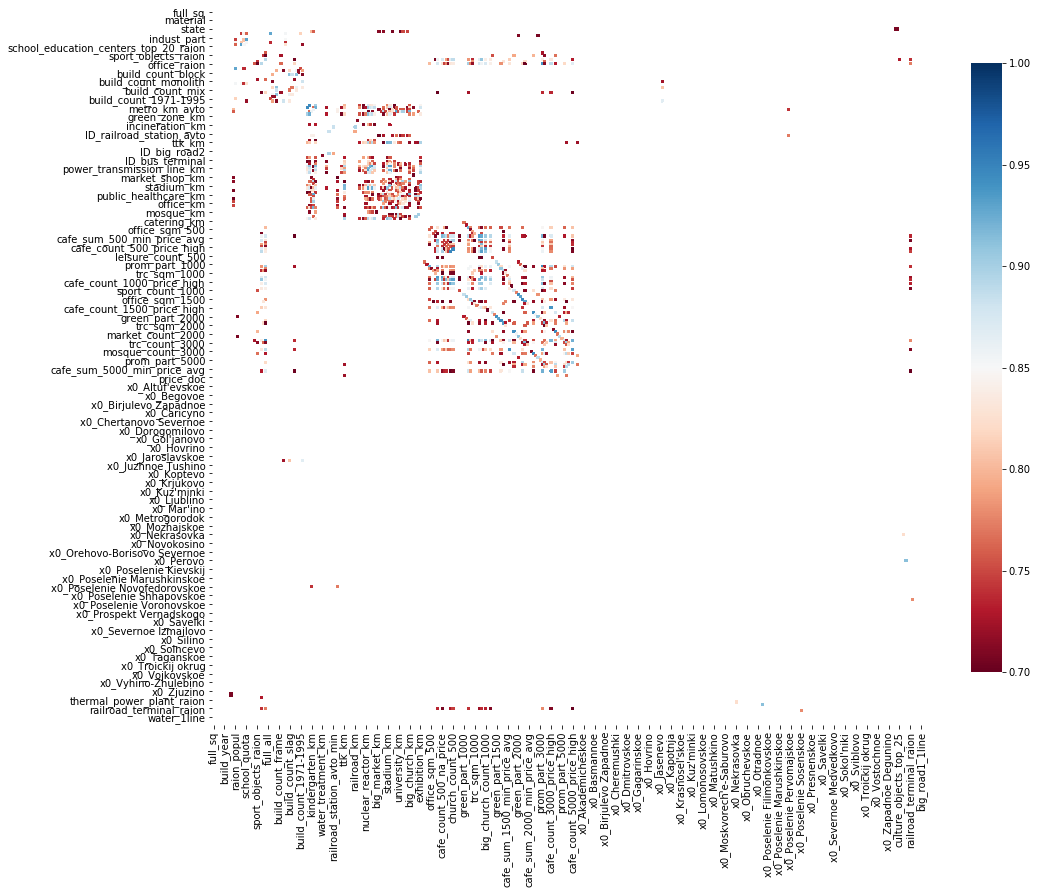

In [272]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 0
col = pp_columns[2:]#new_all_cols[n]

col = [c for c in col if c not in drop_corr_cols_2]
df_drop_na = df_prepro_data_v0[col].dropna()
#corr_cols = df_drop_na.where(df_drop_na.values>0.1).dropna().index.tolist()

corr = df_prepro_data_v0[col].corr().abs()

corr = corr[(corr >= 0.7) & (corr.values != 1.0) ]#.dropna(how='all').dropna(axis=1, how='all')
corr_min = corr.min().min()
corr_max = corr.max().max()
print(corr_min, corr_max)

#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0.7,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

'''clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');''';

In [285]:
'price_doc' in drop_corr_cols_3

False

In [291]:
missing = [(c, df_prepro_data_v0[c].isna().mean()*100) for c in df_prepro_data_v0]
missing = pd.DataFrame(missing, columns=["column_name", "percent_missing"])
missing = missing[missing.percent_missing > 10]
display(missing.sort_values("percent_missing", ascending=False)[:10])

,column_name,percent_missing
22,hospital_beds_raion,47.392603
7,build_year,44.649011
10,state,44.498047
145,cafe_sum_500_min_price_avg,43.585704
146,cafe_sum_500_max_price_avg,43.585704
147,cafe_avg_price_500,43.585704
5,max_floor,31.413475
6,material,31.413475
8,num_room,31.413475
9,kitch_sq,31.413475


In [292]:
missing.shape

(10, 2)

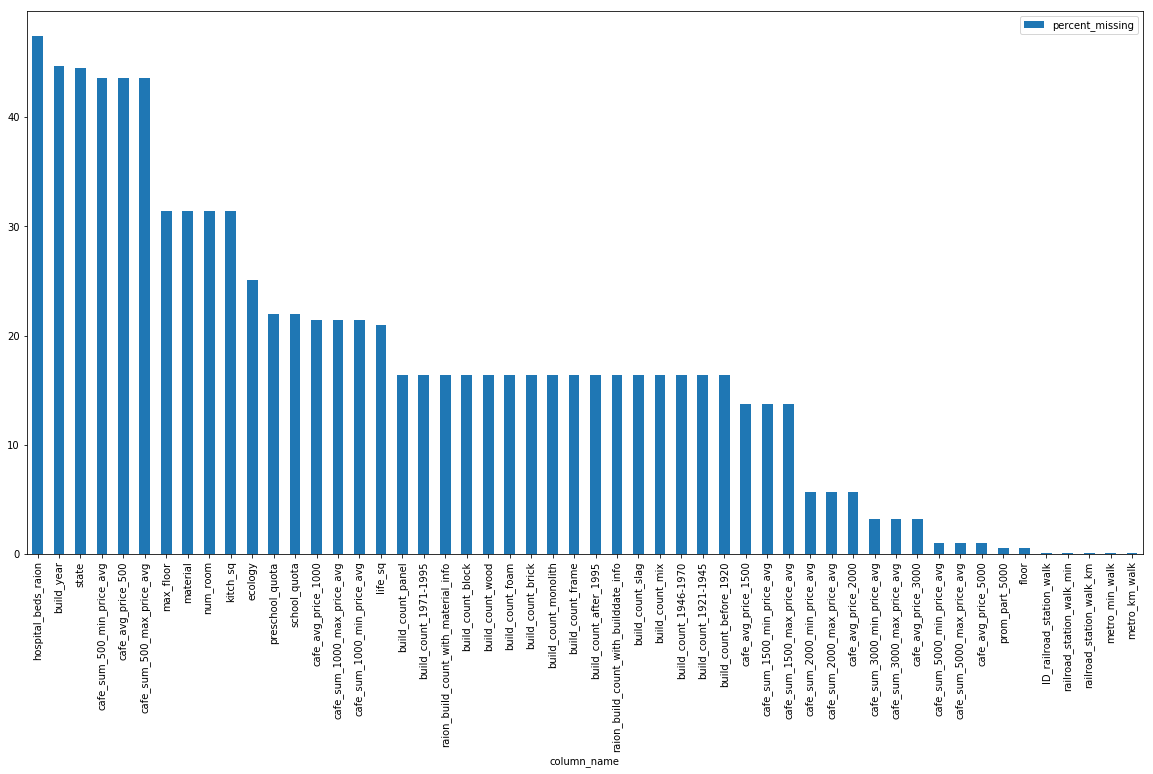

In [335]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
missing.sort_values("percent_missing", ascending=False).plot.bar(x='column_name',y='percent_missing', ax=ax)

In [11]:
df.shape, missing.shape

((30471, 292), (51, 2))

In [16]:
df[missing.column_name.tolist()].head()

,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,preschool_quota,school_quota,...,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,prom_part_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000
0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5001.0,11065.0,...,614.29,1042.86,828.57,639.68,1079.37,859.52,13.31,708.57,1185.71,947.14
1,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3119.0,6237.0,...,695.24,1190.48,942.86,631.03,1086.21,858.62,27.47,673.81,1148.81,911.31
2,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1463.0,5580.0,...,563.64,977.27,770.45,697.44,1192.31,944.87,21.58,702.68,1196.43,949.55
3,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,6839.0,17063.0,...,660.00,1120.00,890.00,718.75,1218.75,968.75,3.89,931.58,1552.63,1242.11
4,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3240.0,7770.0,...,765.93,1269.23,1017.58,853.03,1410.45,1131.74,10.92,853.88,1411.45,1132.66


In [352]:
df[missing.column_name.tolist()].describe()

,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,preschool_quota,school_quota,...,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,prom_part_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,ecology
count,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,23783.000000,23786.000000,...,28746.000000,28746.000000,29480.000000,29480.000000,29480.000000,30293.000000,30174.000000,30174.000000,30174.000000,22815.000000
mean,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,3271.272464,8324.970739,...,1210.908134,965.443455,765.900619,1283.334756,1024.617808,10.348669,765.098467,1278.280635,1021.689513,1.308218
std,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,2169.759592,4289.734174,...,302.826289,250.014353,224.006719,353.299663,288.163451,5.668748,152.408951,236.207686,194.117696,1.123102
min,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1012.000000,...,500.000000,400.000000,300.000000,500.000000,400.000000,0.210000,300.000000,500.000000,400.000000,0.000000
25%,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,1874.000000,5782.000000,...,1000.000000,823.470000,650.000000,1102.270000,875.797500,6.050000,670.870000,1144.230000,909.380000,0.000000
50%,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,2854.000000,7377.000000,...,1156.250000,919.230000,711.110000,1211.540000,961.110000,8.980000,721.740000,1211.945000,966.670000,1.000000
75%,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,4050.000000,9891.000000,...,1321.625000,1057.240000,815.630000,1333.330000,1083.330000,14.000000,816.657500,1346.090000,1091.670000,2.000000
max,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,11926.000000,24750.000000,...,3500.000000,2833.330000,1833.330000,3000.000000,2416.670000,28.560000,1875.000000,3000.000000,2437.500000,3.000000


In [354]:
missing_col_names = missing.column_name.values.tolist()

In [456]:
all_cols = df.columns.tolist()

In [457]:
all_full_cols = [item for item in all_cols if item not in missing_col_names]

In [458]:
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

X = df.filter(all_full_cols, axis=1).select_dtypes(include='number')

In [459]:
X.shape

(30471, 239)

In [463]:
for e in df.columns: 
    if ('price' in e) & ('_price_' not in e): 
        print(e) 

cafe_count_500_na_price
cafe_count_1000_na_price
cafe_count_1500_na_price
cafe_count_2000_na_price
cafe_count_3000_na_price
cafe_count_5000_na_price
price_doc


#### Try first with XGBoost

In [464]:
import xgboost as xgb

1. Set up the data: remove `id` and target feature, `price_doc`

In [469]:
X = df.filter(all_full_cols, axis=1).select_dtypes(include='number').drop(["id", "price_doc"], axis=1).copy()
y = df.filter(all_full_cols, axis=1).price_doc.values

2. Run XGB's feature importance method (internal)

In [472]:
clf = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1)
coeffs = clf.fit(X, y).feature_importances_

3. Save to DF

In [483]:
df_co = pd.DataFrame(coeffs, columns=["importance_"])
df_co.index = X.columns
df_co.sort_values("importance_", ascending=True, inplace=True)
# Get relative importance
df_co['normed_importance_'] = df_co.importance_.apply(lambda x: x/df_co.importance_.max())

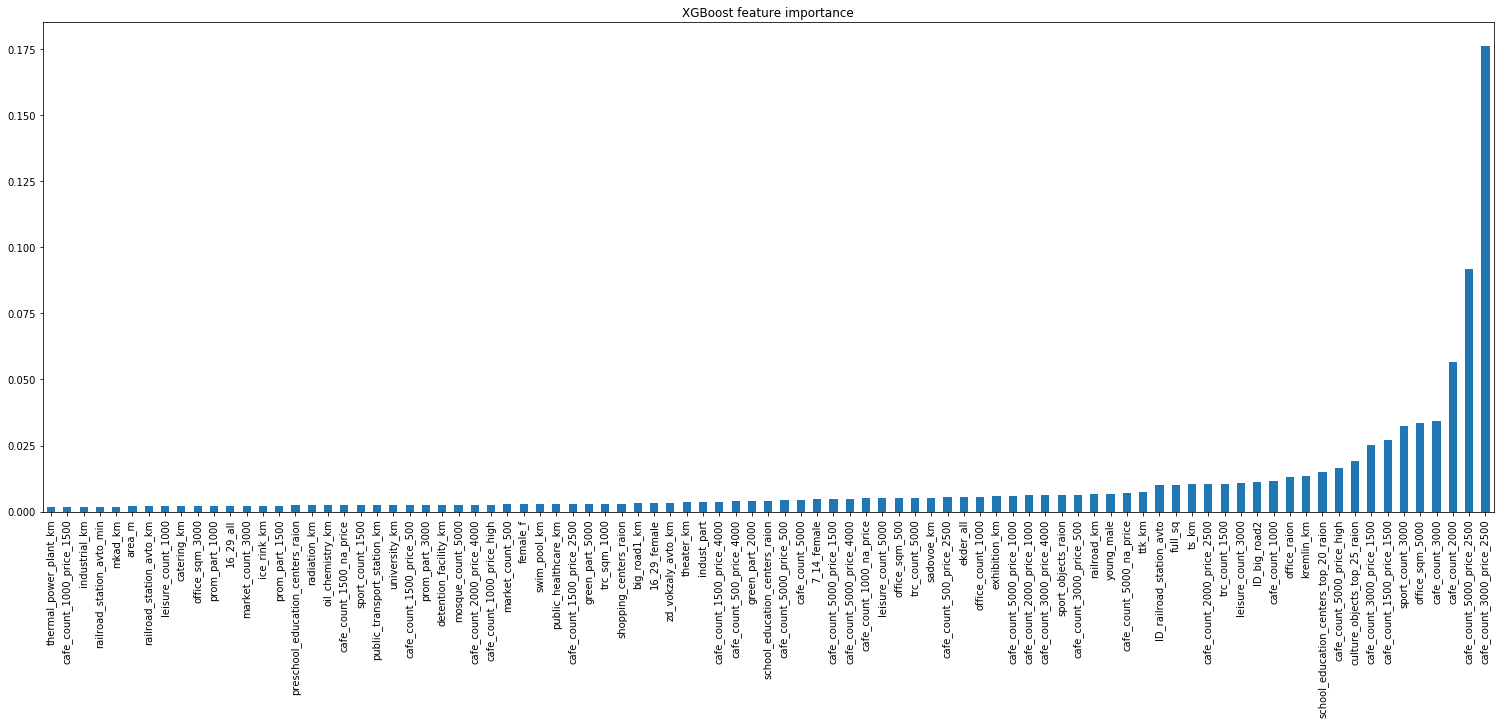

In [484]:
plt.figure(figsize=(26,9))
#df_co[df_co['importance_']>0.00175].importance_.plot(kind="bar")
df_co[df_co['normed_importance_']>0.01].importance_.plot(kind="bar")
plt.title(f"XGBoost feature importance")
plt.show()

#### Try with other ensemple regressors

In [507]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

import lightgbm as lgb

In [511]:
classifiers = [
               RandomForestRegressor(),
               GradientBoostingRegressor(),
               AdaBoostRegressor(),
               lgb.LGBMRegressor(),
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = ["rfo","gbm", "ada", "lgb", "xgb"];

1. Compute the feature importance with the classifiers
    * using defaults (some from `sklearn`; `xgb` and `lgb` are their own)

In [512]:
n=0
pdf_co = pd.DataFrame()
for clf_name, clf in zip(clf_names, classifiers):
    print(clf_name)
    %time coeffs = clf.fit(X, y).feature_importances_
    df_co = pd.DataFrame(coeffs, columns=["importance_"+clf_name.strip()])
    df_co.index = X.columns
    print(df_co.shape)
    pdf_co = pd.concat([pdf_co, df_co], axis=1)
    print(df_co.shape, pdf_co.shape)    
    n+=1

rfo
CPU times: user 6min 23s, sys: 316 ms, total: 6min 23s
Wall time: 6min 24s
(237, 1)
(237, 1) (237, 1)
gbm
CPU times: user 1min 25s, sys: 77.9 ms, total: 1min 25s
Wall time: 1min 25s
(237, 1)
(237, 1) (237, 2)
ada
CPU times: user 35.5 s, sys: 1.18 s, total: 36.7 s
Wall time: 36.7 s
(237, 1)
(237, 1) (237, 3)
lgb
CPU times: user 6.06 s, sys: 103 ms, total: 6.16 s
Wall time: 6.18 s
(237, 1)
(237, 1) (237, 4)
xgb
CPU times: user 39.6 s, sys: 74.3 ms, total: 39.6 s
Wall time: 39.7 s
(237, 1)
(237, 1) (237, 5)


In [514]:
pdf_co.head()

,importance_rfo,importance_gbm,importance_ada,importance_lgb,importance_xgb
full_sq,0.427127,0.567171,0.260874,526,0.010191
area_m,0.001799,0.001995,0.000238,5,0.001914
raion_popul,0.000463,0.000000,0.000000,2,0.001127
green_zone_part,0.002540,0.005377,0.016906,14,0.001718
indust_part,0.002373,0.005299,0.002924,19,0.003689


In [518]:
pdf_co.describe()

,importance_rfo,importance_gbm,importance_ada,importance_lgb,importance_xgb,normed_importance_rfo,normed_importance_gbm,normed_importance_ada,normed_importance_lgb,normed_importance_xgb
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,0.004219,0.004219,0.004219,12.658228,0.004219,0.009879,0.007439,0.016174,0.024065,0.023925
std,0.027923,0.037266,0.018474,35.286438,0.014040,0.065373,0.065704,0.070816,0.067084,0.079610
min,0.000001,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000
25%,0.000499,0.000000,0.000000,2.000000,0.000683,0.001168,0.000000,0.000000,0.003802,0.003873
50%,0.001207,0.000170,0.000000,7.000000,0.001394,0.002826,0.000300,0.000000,0.013308,0.007903
75%,0.003108,0.001000,0.002869,14.000000,0.002694,0.007276,0.001763,0.010998,0.026616,0.015273
max,0.427127,0.567171,0.260874,526.000000,0.176361,1.000000,1.000000,1.000000,1.000000,1.000000


2. Normalized the `feature_importance` cols
    * Don't know what this means for the relative importance

In [516]:
all_cols = ['importance_' + e for e in clf_names]
new_all_cols = []
for col in all_cols:
    new_col = 'normed_' + col
    pdf_co[new_col] = pdf_co[col].apply(lambda x: x/pdf_co[col].max())
    new_all_cols.append(new_col)

3. Plot the results for comparison

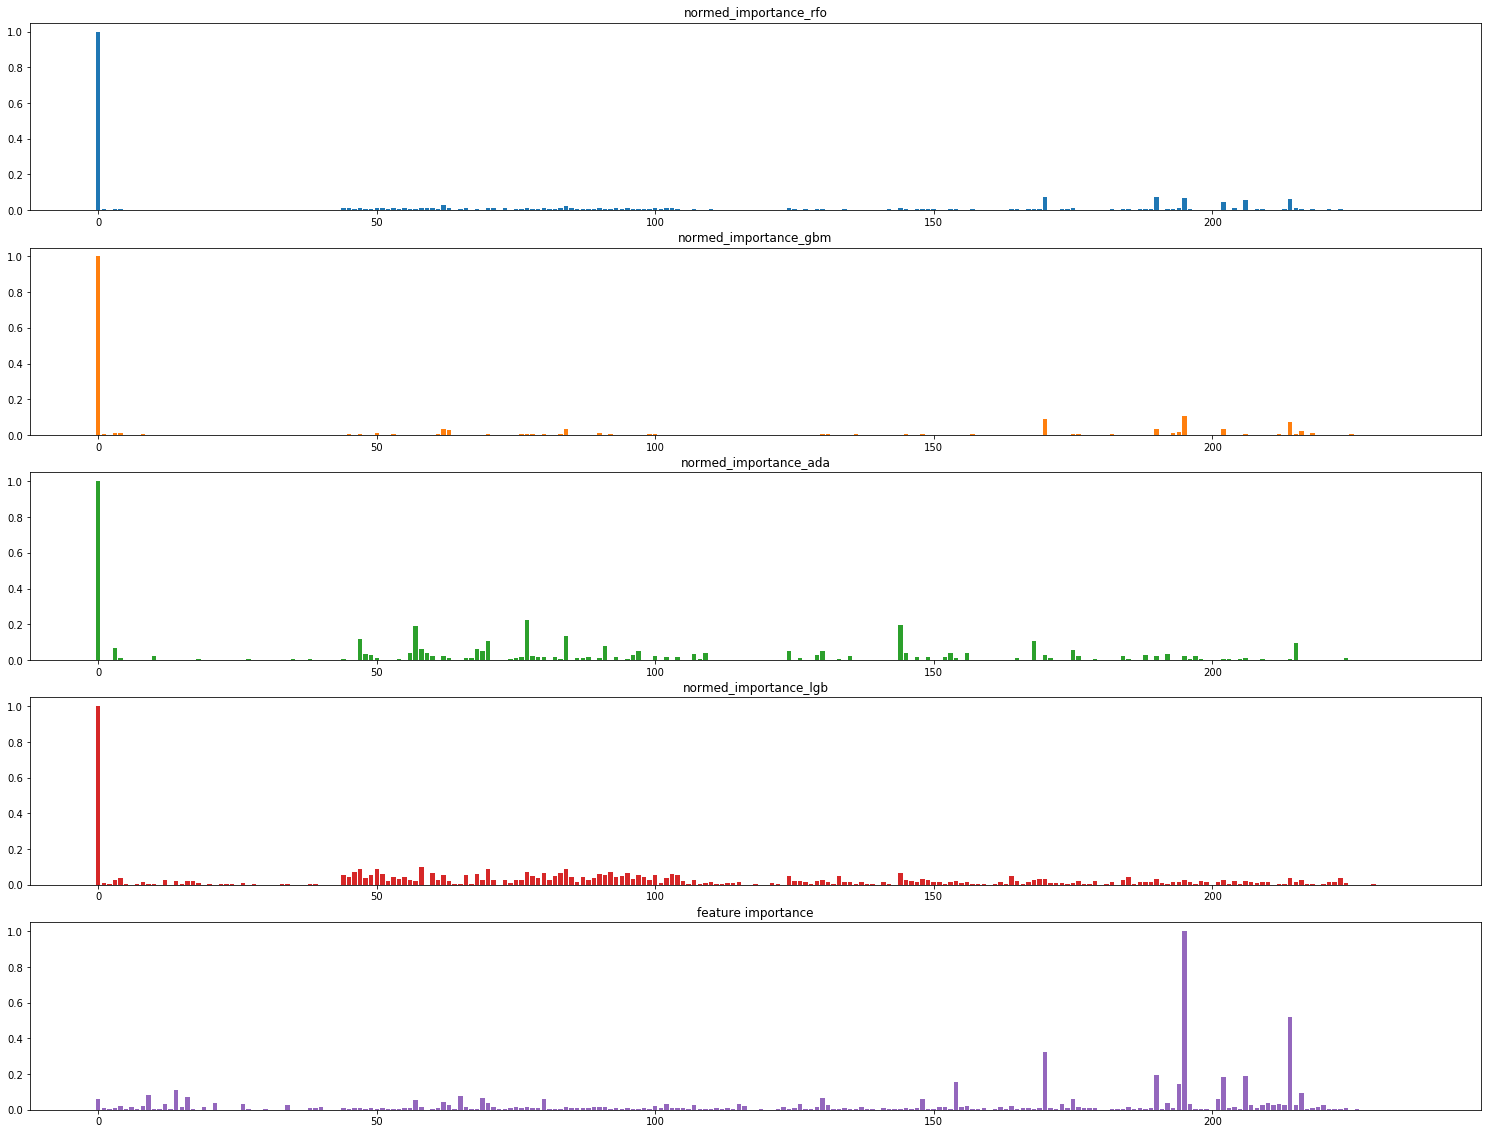

In [524]:

len_new_all_cols = len(new_all_cols)

fig, axs = plt.subplots(len_new_all_cols,1, figsize=(26,20))

axs =axs.reshape(len_new_all_cols)

colors = ['C'+str(e) for e in range(len_new_all_cols)]

n = 0
for col in new_all_cols:
    ax=axs[n]
    xx = pdf_co.reset_index().index.values
    yy = pdf_co[col].values
    ax.bar(xx,yy, color=colors[n])
    
    ax.set_title(col)
    n+=1
    
plt.title(f"feature importance")
plt.show()

Filtering out the NANs

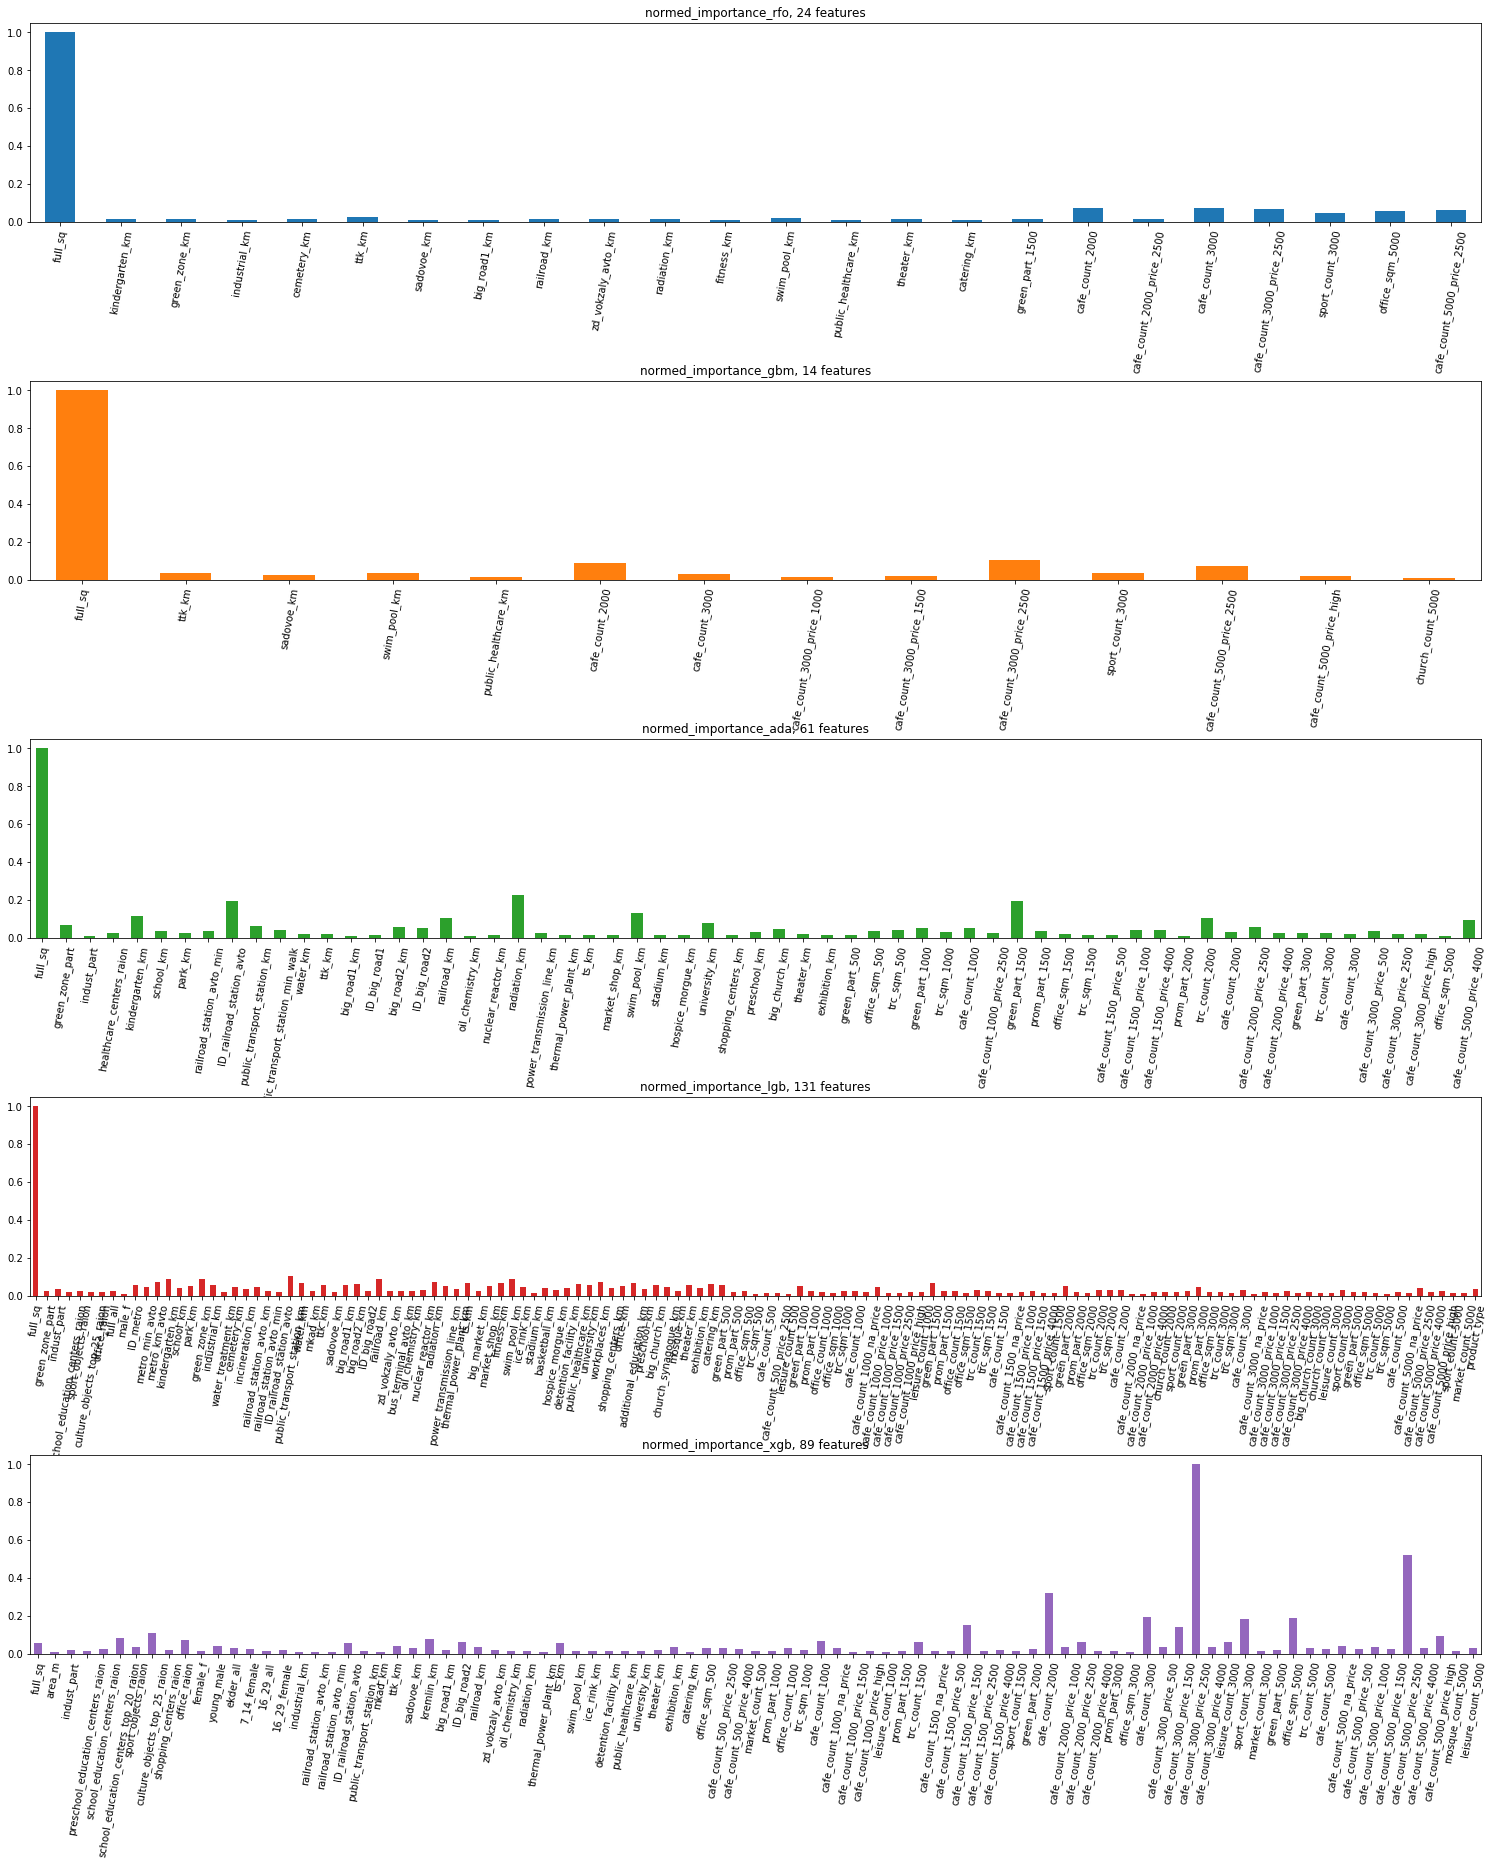

In [536]:
fig, axs = plt.subplots(len_new_all_cols,1, figsize=(26,30))
plt.subplots_adjust( hspace = 0.8)

axs =axs.reshape(len_new_all_cols)

n = 0
for col in new_all_cols:
    ax=axs[n]
    pdf_sub = pdf_co[col].where(pdf_co[col].values>0.01).dropna(how='all')
    nr_cols = len(pdf_sub.index.tolist())
    pdf_sub.plot(kind="bar", ax= ax, color=colors[n])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title(f'{col}, {nr_cols} features')
    n+=1
    
#plt.subplots_adjust( hspace = 0.2)

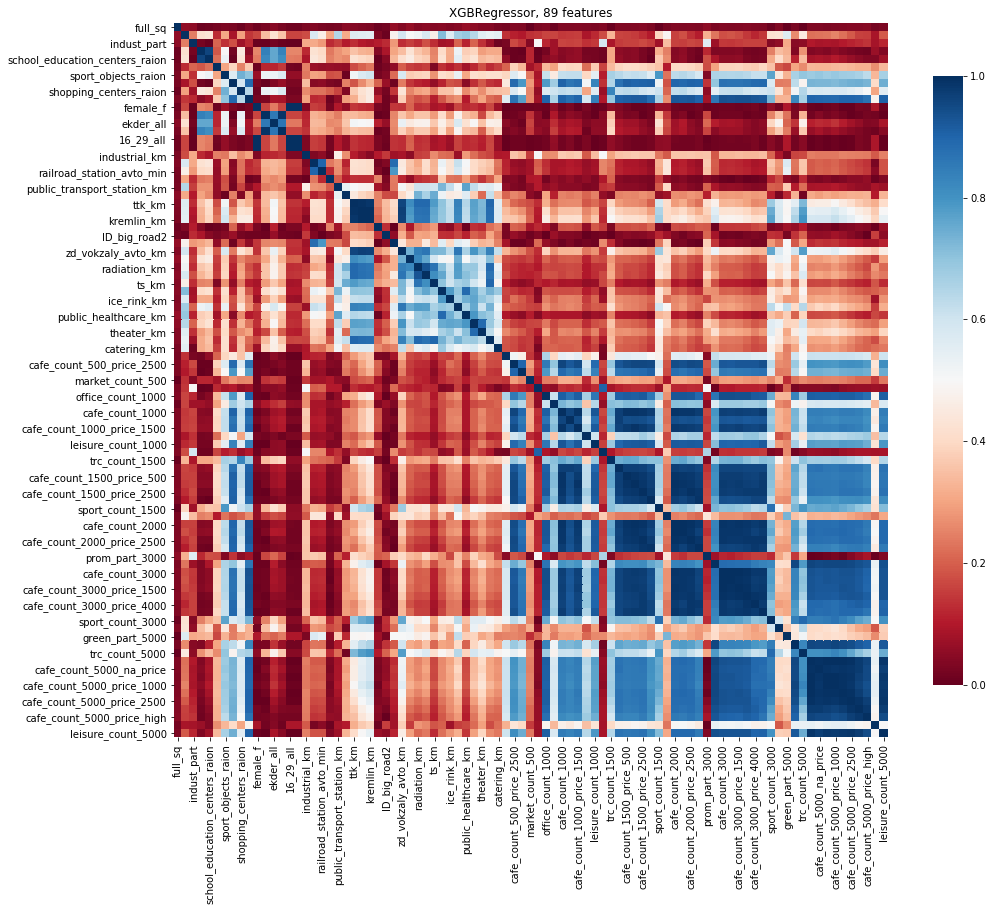

In [595]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 4
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

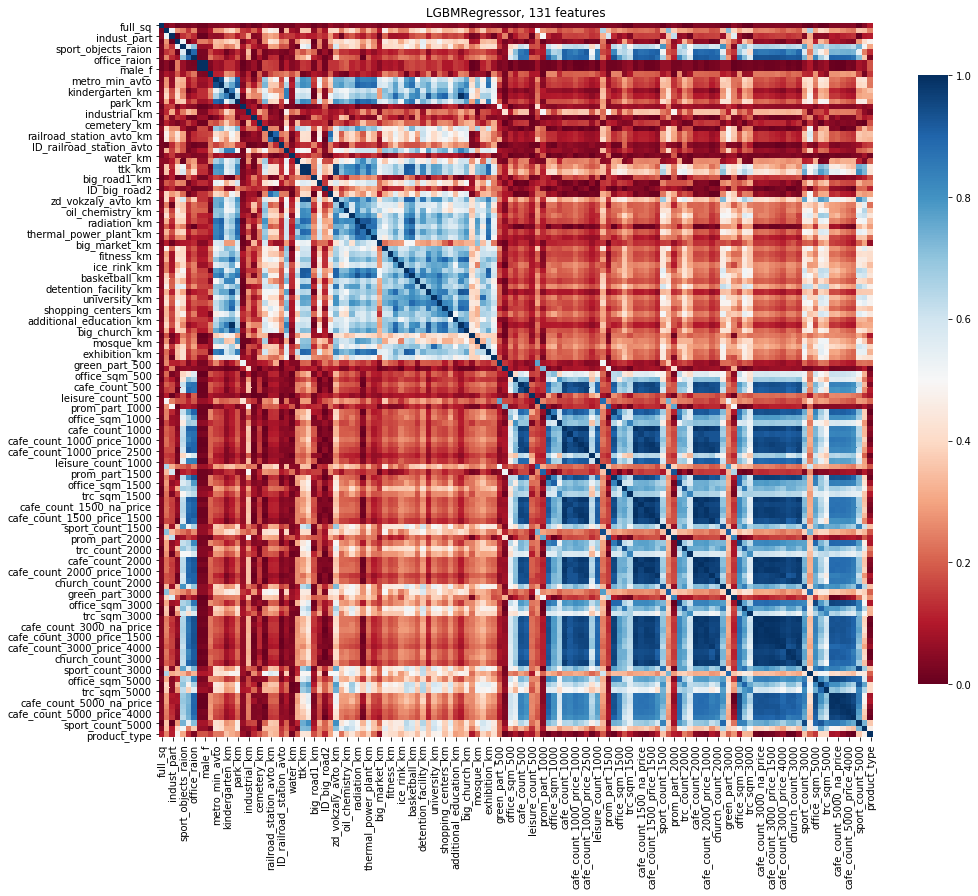

In [594]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 3
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

#### Note: the remaining features are still mutually correlated

In [568]:
name_to_classif = dict(zip(clf_names, classifiers))

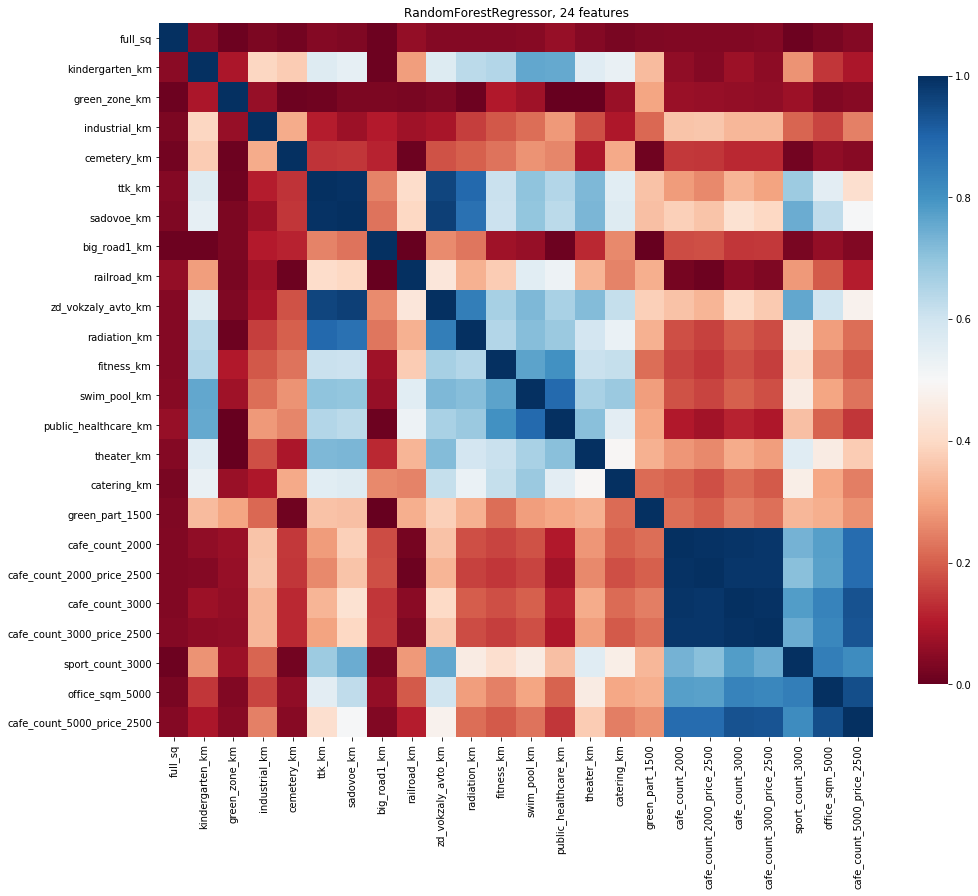

In [591]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 0
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

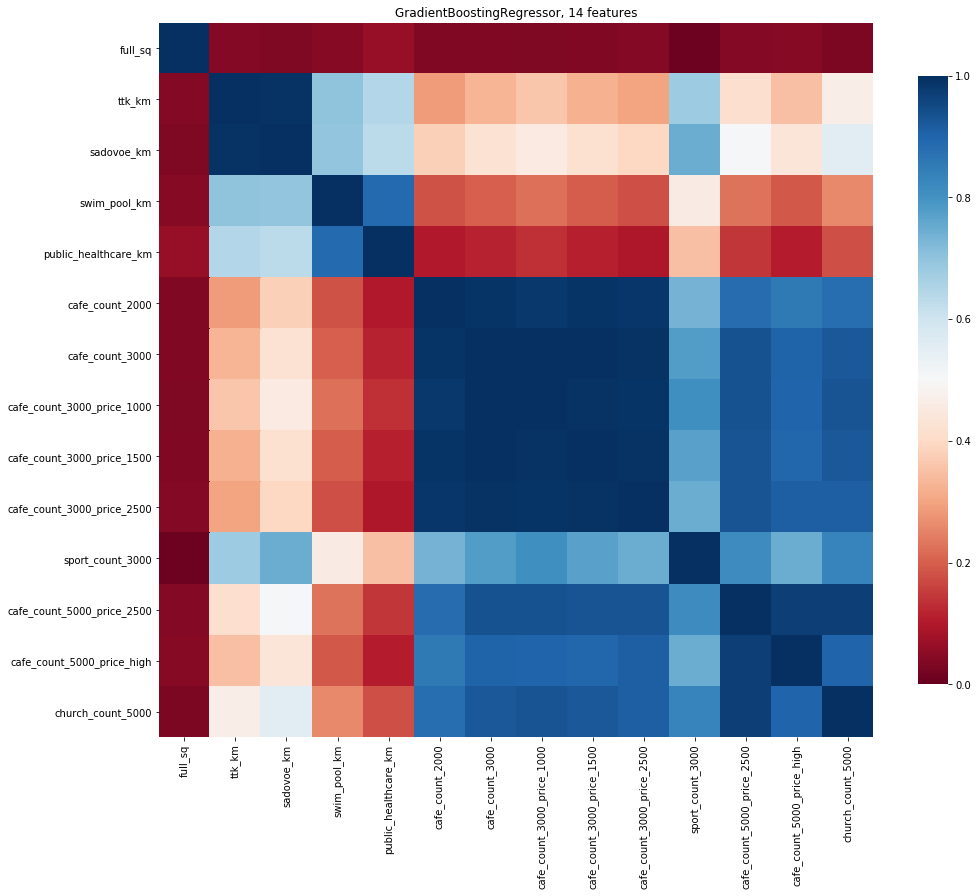

In [592]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 1
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');

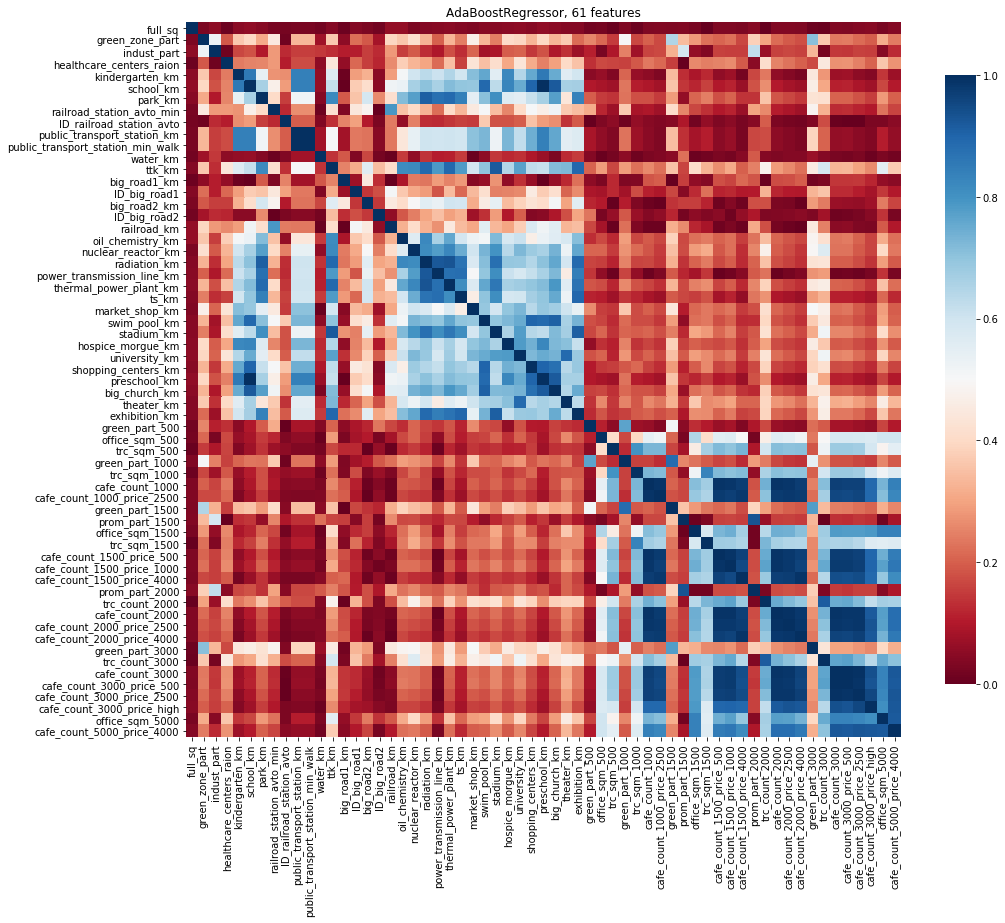

In [593]:
fig, ax = plt.subplots(1,1, figsize=(16,16))

n = 2
col = new_all_cols[n]

corr_cols = pdf_co[col].where(pdf_co[col].values>0.01).dropna().index.tolist()

corr = df[corr_cols].corr()
#sns.heatmap(corr, cmap="RdBu", vmin=-1.,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);
sns.heatmap(np.abs(corr), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax);

clf= type(name_to_classif[col.split('normed_importance_')[1]]).__name__
plt.title(f'{clf}, {len(corr_cols)} features');